(GLM_linear)=
# GLM: Linear regression

This tutorial is adapted from a [blog post by Thomas Wiecki called "The Inference Button: Bayesian GLMs made easy with PyMC"](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/).

While the theoretical benefits of Bayesian over frequentist methods have been discussed at length elsewhere (see *Further Reading* below), the major obstacle that hinders wider adoption is *usability*.  This is mildly ironic because the beauty of Bayesian statistics is their generality. Frequentist stats involve coming up with a test statistic that is specific for the application at hand, whereas with Bayes you define your model exactly as you think is appropriate and hit the *Inference Button(TM)* (i.e. running the magical MCMC sampling algorithm).

Over the past few decades, some great Bayesian software packages have been created including [JAGS](http://mcmc-jags.sourceforge.net/), [BUGS](http://www.mrc-bsu.cam.ac.uk/bugs/), and [Stan](http://mc-stan.org/), however they are written for statisticians who know very well what model they want to build. 

Unfortunately, ["the vast majority of statistical analysis is not performed by statisticians"](http://simplystatistics.org/2013/06/14/the-vast-majority-of-statistical-analysis-is-not-performed-by-statisticians/) -- so what we really need are tools for *scientists* and not for statisticians. PyMC3 makes it easy to construct statistical models for the application at hand, independent of how the various fitting algorithms are implemented.

## Linear Regression

In this example, we will start with the simplest GLM -- linear regression.
In general, frequentists think about linear regression as follows:

$$ Y = X\beta + \epsilon $$

where $Y$ is the output we want to predict (or *dependent* variable), $X$ is our predictor (or *independent* variable), and $\beta$ are the coefficients (or parameters) of the model we want to estimate. $\epsilon$ is an error term which is assumed to be normally distributed. 

We can then use ordinary least squares (OLS) or maximum likelihood to find the best fitting $\beta$.

## Probabilistic Reformulation

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be reformulated as:

$$ Y \sim \mathcal{N}(X \beta, \sigma^2) $$

In words, we view $Y$ as a random variable (or random vector) of which each element (data point) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

While this is essentially the same model, there are two critical advantages of Bayesian estimation:

 - Priors: We can quantify any prior knowledge we might have by placing priors on the paramters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.
 - Quantifying uncertainty: We do not get a single estimate of $\beta$ as above but instead a complete posterior distribution about how likely different values of $\beta$ are. For example, with few data points our uncertainty in $\beta$ will be very high and we'd be getting very wide posteriors.

## Bayesian GLMs in PyMC

To get started building GLMs in PyMC, let's first import the required modules.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your Python environment has Theano(-PyMC) 1.1.2 installed, but you are importing PyMC 4.0.0b1 which uses Aesara as its backend.
For PyMC 4.0.0b1 to work as expected you should uninstall Theano(-PyMC).
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
You are importing PyMC 4.0.0b1, but your environment also has the legacy version PyMC3 3.11.4 installed.
For PyMC 4.0.0b1 to work as expected you should uninstall PyMC3.
See https://github.com/pymc-devs/pymc/wiki for update instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Running on PyMC v4.0.0b1


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

### Generating data

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

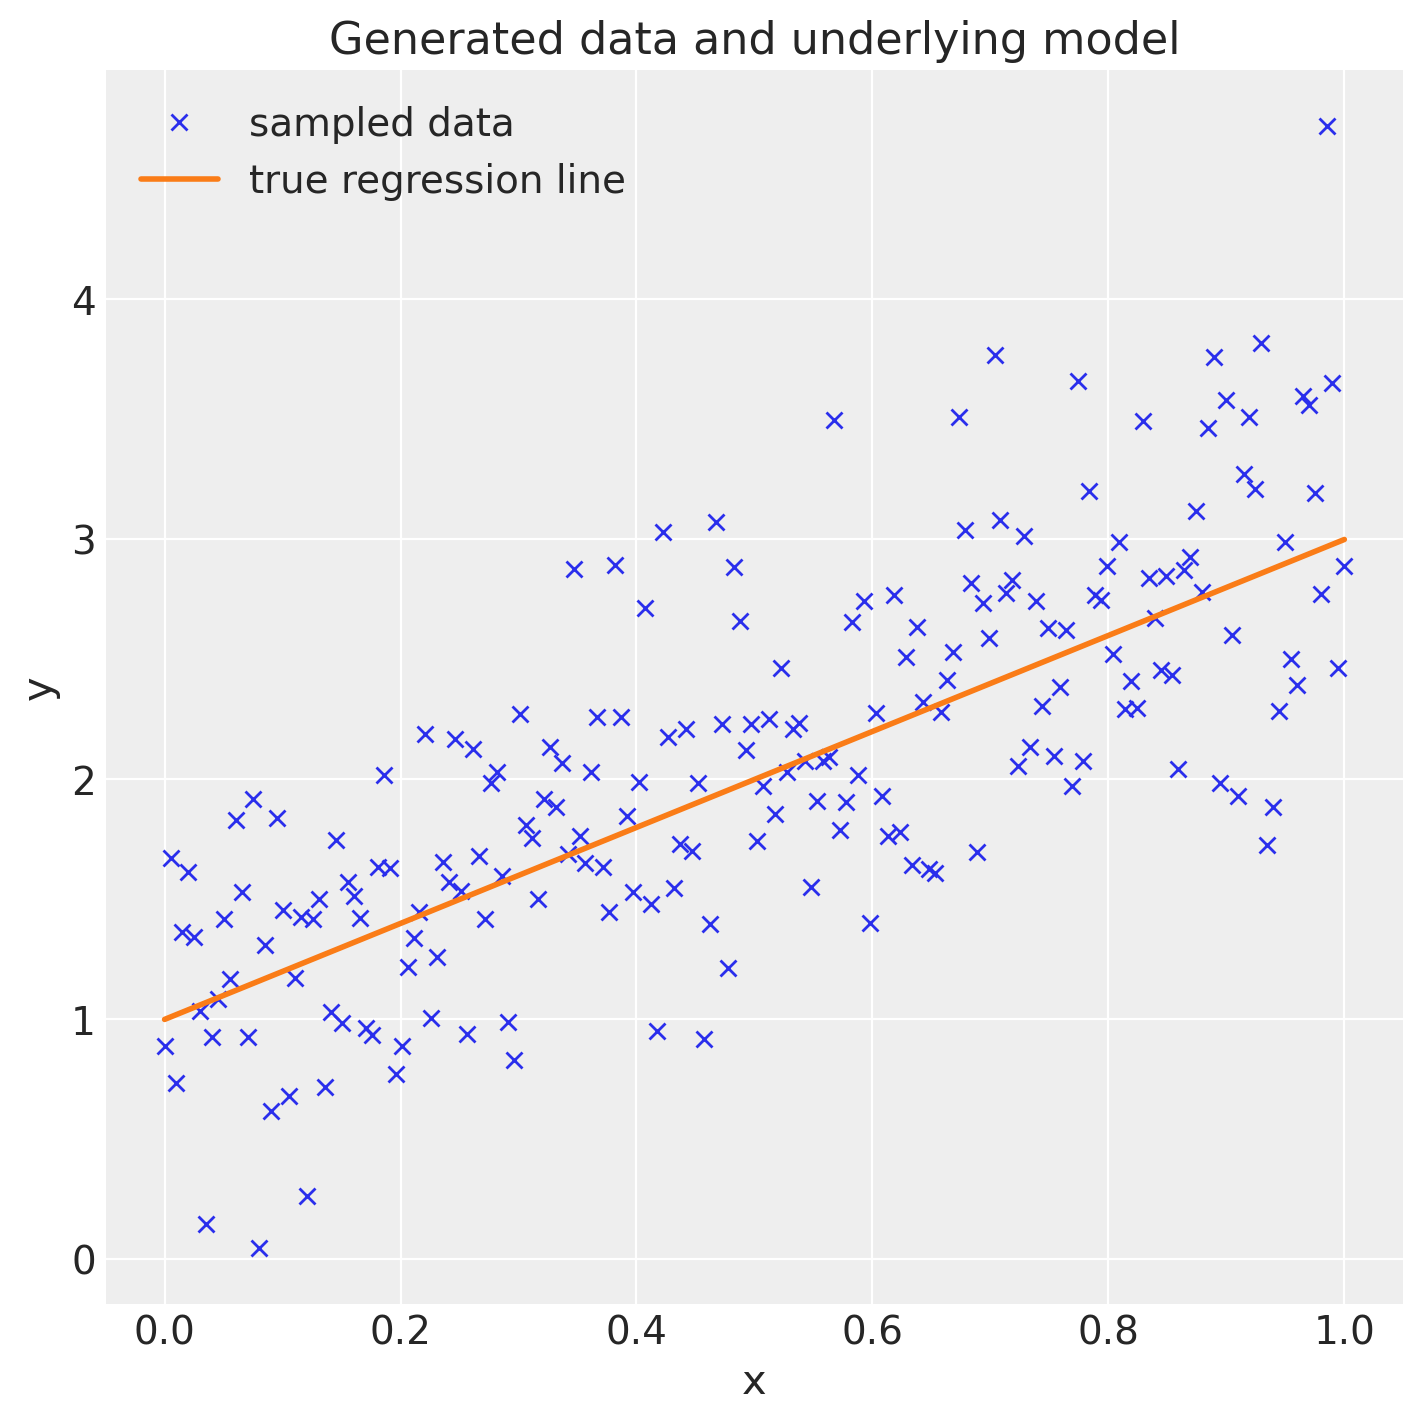

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

### Estimating the model

Lets fit a Bayesian linear regression model to this data. In PyMC, the model specifications takes place in a `with` expression, called a context manager. By default, models are fit using the [NUTS sampler](http://arxiv.org/abs/1111.4246), resulting in a trace of samples representing the marginal posterior distribution of the latent model parameters.

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000, return_inferencedata=True)

/tmp/ipykernel_13873/710837242.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  sigma = HalfCauchy("sigma", beta=10, testval=1.0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.


This should be fairly readable for people who know probabilistic programming. However, would a non-statistican know what all this does? Moreover, recall that this is an extremely simple model that would be one line in R. Having multiple, potentially transformed regressors, interaction terms or link-functions would also make this much more complex and error prone. 

To make things even simpler, the [`bambi`](https://bambinos.github.io/bambi/master/index.html) library  takes a [formula](https://bambinos.github.io/formulae/) linear model specifier from which it creates a design matrix. `bambi` then adds random variables for each of the coefficients and an appopriate likelihood to the model. 

If `bambi` is not installed, you can install it with `pip install bambi`.

In [6]:
import sys

try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install bambi
    import bambi as bmb

In [7]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


Much shorter, but this code does the exact same thing as the previous specification (you can change priors and everything else too if we wanted). `bambi` parses the `formulae` model string, adds random variables for each regressor (`Intercept` and slope `x` in this case), adds a likelihood (by default, a Normal is chosen), and all other variables (`sigma`). Finally, `bambi` then initializes the parameters to a good starting point by estimating a frequentist linear model using [statsmodels](http://statsmodels.sourceforge.net/devel/).

If you are not familiar with R's syntax, `'y ~ x'` specifies that we have an output variable `y` that we want to estimate as a linear function of `x`.

### Analyzing the model

Bayesian inference does not give us only one line of best fit (as maximum likelihood does) but rather a whole posterior distribution of plausible parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

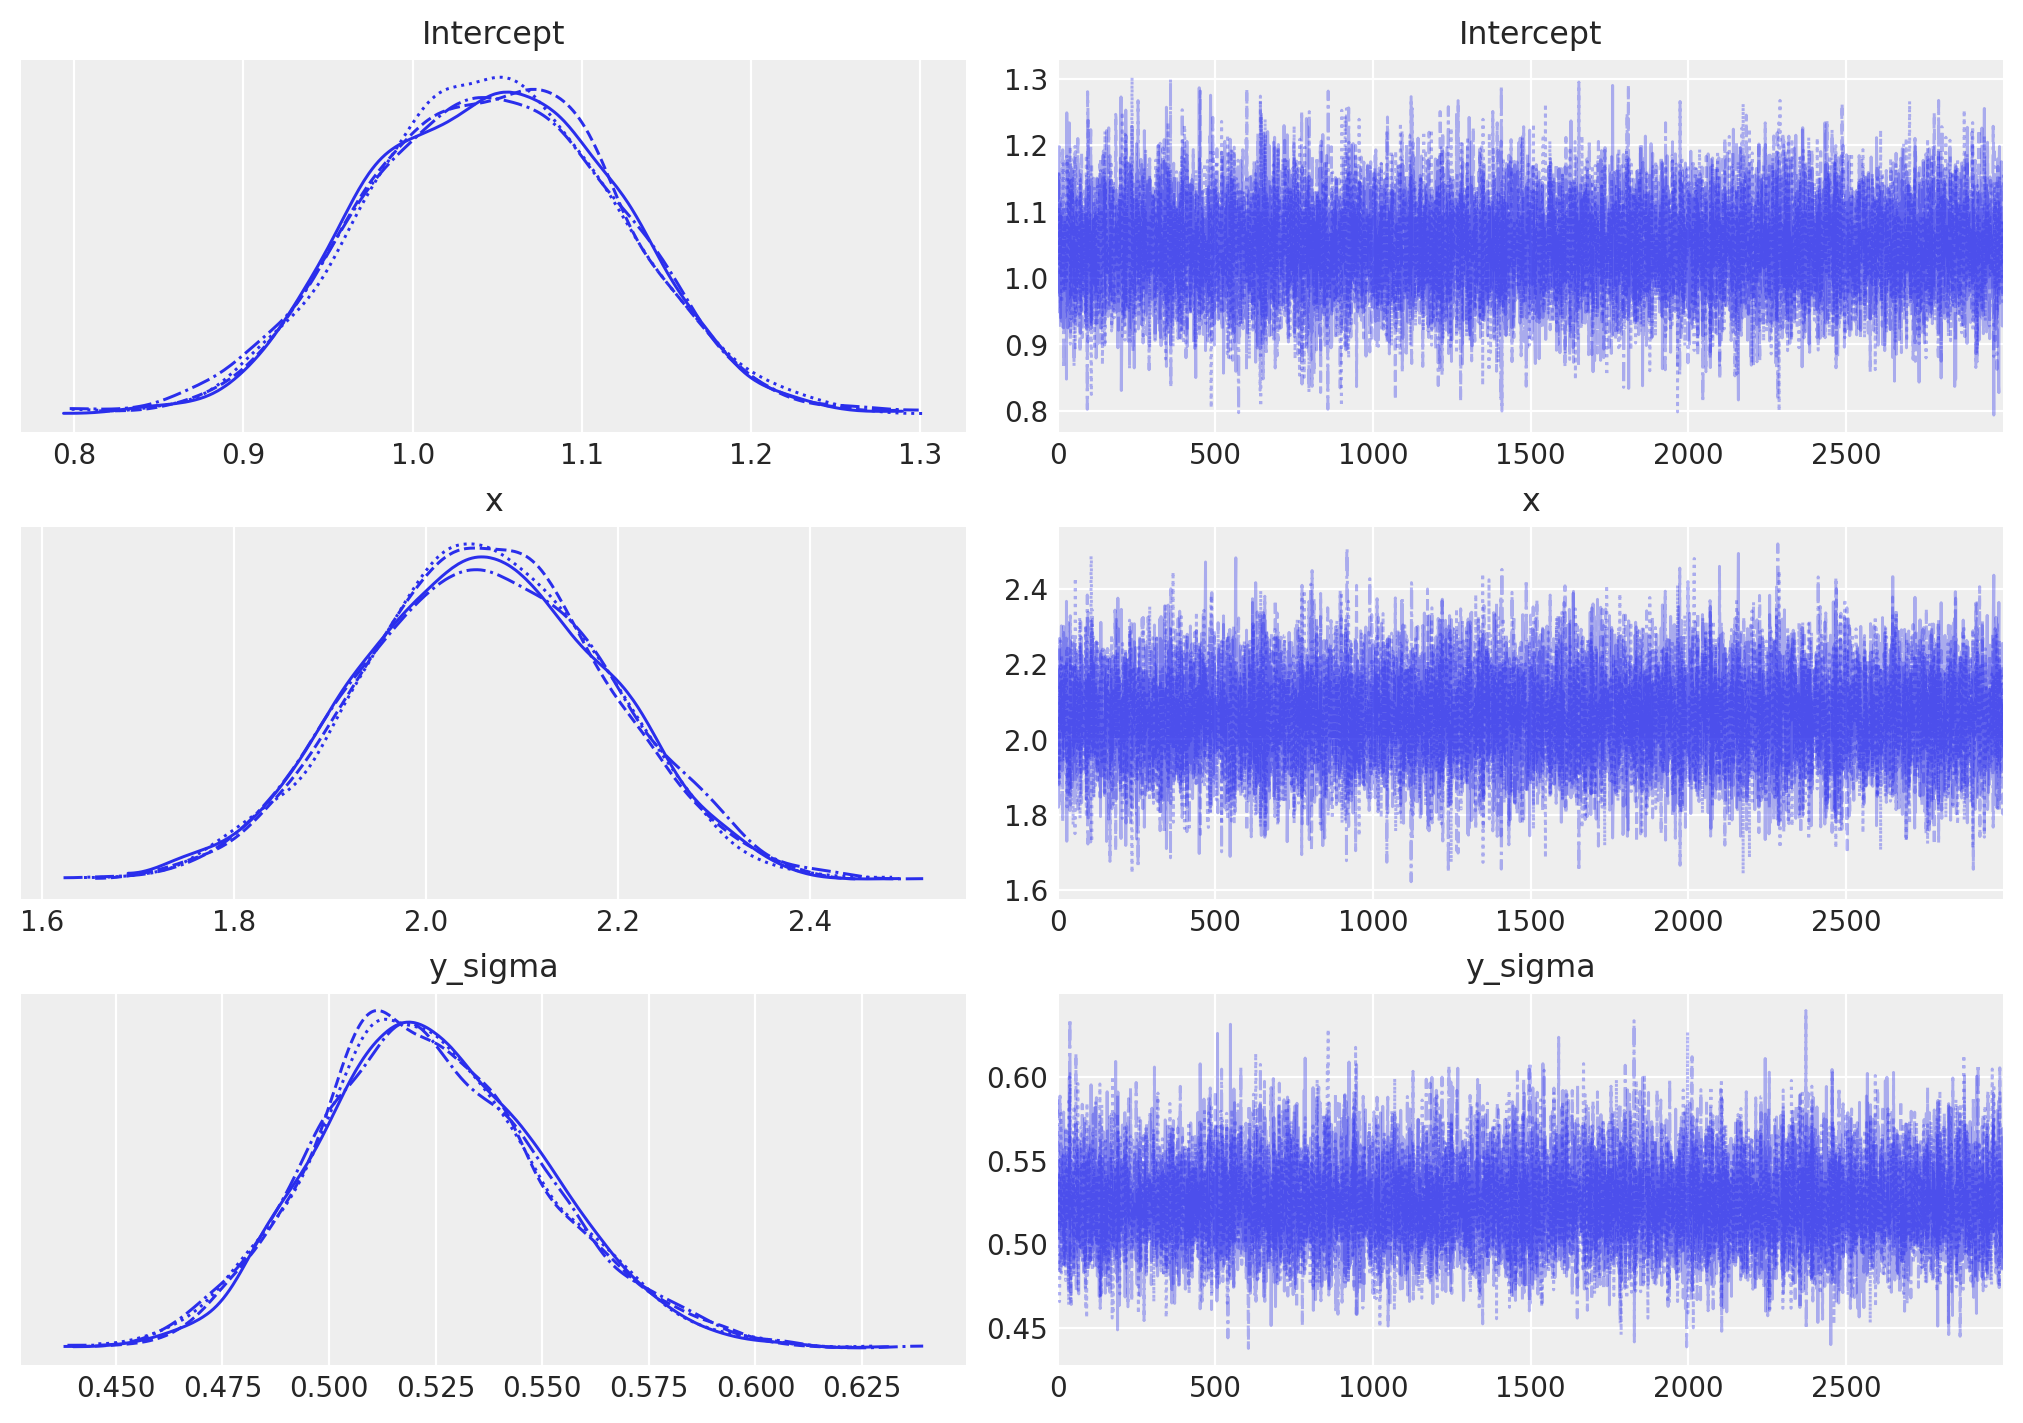

In [8]:
az.plot_trace(idata, figsize=(10, 7));

The left side shows our marginal posterior -- for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem homogeneous and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (`x` is the regression coefficient and `sigma` is the standard deviation of our normal).

In GLMs, we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

In [9]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"]*xr.DataArray(x)

/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/arviz/plots/lmplot.py:200: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)
/home/fonnesbeck/miniforge3/envs/dev/lib/python3.9/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


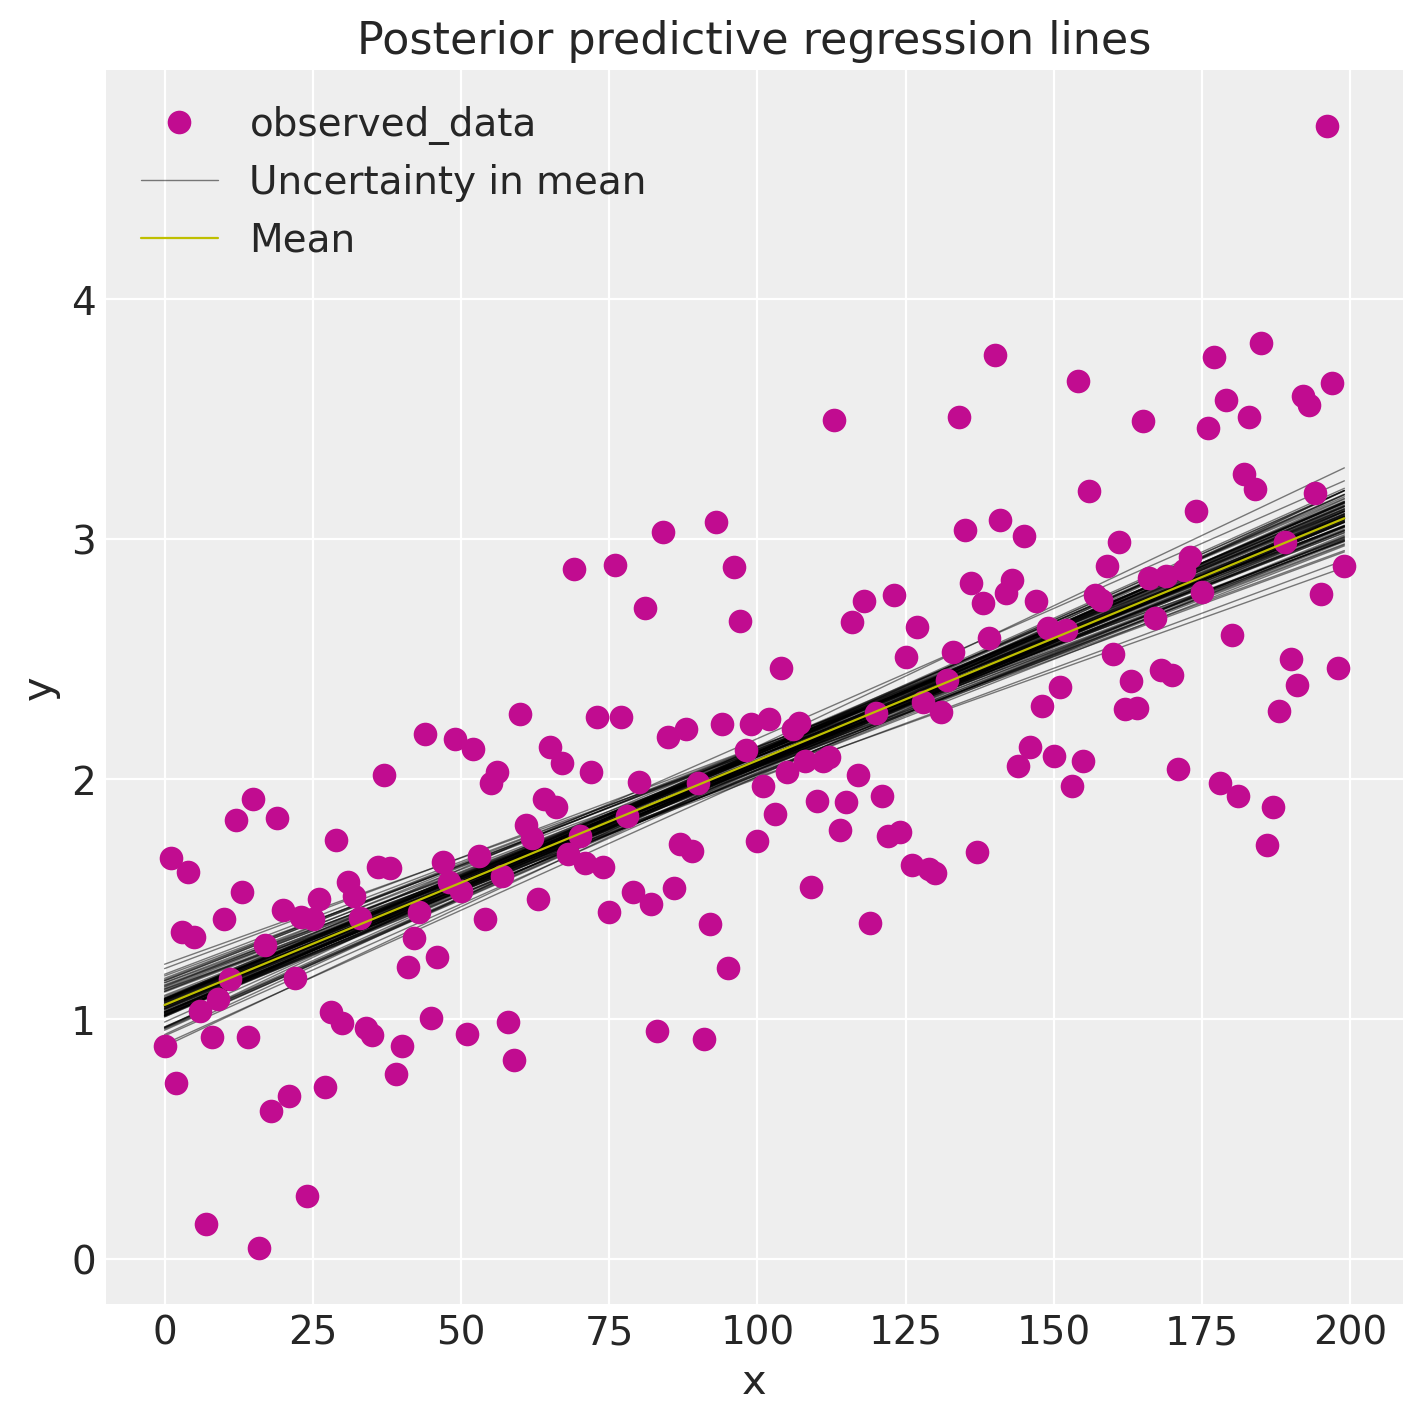

In [10]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have *uncertainty* in our estimates, here expressed by the variability of the lines.

## Summary

 - Usability is currently a huge hurdle for wider adoption of Bayesian statistics.
 - `Bambi` allows GLM specification with convenient syntax borrowed from R. Inference can then be carried out with `pymc`.
 - Posterior predictive plots allow us to evaluate fit and our uncertainty in it.

### Further reading

For additional background, here are a few good resources on Bayesian statistics:

  - The excellent book [Doing Bayesian Data Analysis by John Kruschke](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/).
  - [Andrew Gelman's blog](http://andrewgelman.com/)
  - [Baeu Cronins blog post on Probabilistic Programming](https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1)
  
Author: Thomas Wiecki

In [11]:
%load_ext watermark

%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Sat Dec 18 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.30.1

theano: 1.1.2
xarray: 0.20.2

arviz     : 0.11.4
bambi     : 0.6.3
numpy     : 1.21.4
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
pandas    : 1.3.5
pymc      : 4.0.0b1
xarray    : 0.20.2
matplotlib: 3.5.1

Watermark: 2.2.0

